In [35]:
import numpy as np
from sklearn import datasets

import pandas as pd
dataset = datasets.fetch_california_housing(as_frame = True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

dataset.frame_normalized = StandardScaler().fit_transform(dataset.frame)
X = dataset.frame_normalized[:,0:len(dataset.frame.columns) - 2]
y = dataset.frame_normalized[:,len(dataset.frame.columns) - 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)


In [36]:
# dataset.frame.columns

In [37]:
loss = lambda X, y, theta: np.mean((np.dot(X,theta)-y)**2)
D = []

In [60]:
import math
def heavy_ball(f,grad,th0,max_iter,mu,L, gamma=-1, step=-1):
    # Gradient descent with momentum for mu-strongly convex and L-smooth functions
    n = th0.shape[0]
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((n, max_iter+1))
    vals = np.zeros(max_iter+1)
    loss_evol = np.zeros(max_iter+1)
    
    iterates[:,0] = th0
    vals[0] = f(th0)
    
    theta = th0
    m = grad(th0) # initial momentum
    if gamma==-1:
        gamma = (math.sqrt(L)-math.sqrt(mu))**2 / (math.sqrt(L)+math.sqrt(mu))**2 # momentum parameter
    if step==-1:
        step = 1 / math.sqrt(mu*L)
    for t in range(1,max_iter+1):
        m = (1-gamma) * grad(theta) + gamma * m # average current momentum and gradient
        theta = theta - step * m # "gradient" step
        iterates[:,t] = theta
        vals[t] = f(theta)
        temp = loss(X_train, y_train, theta)
        loss_evol[t] = temp
    
    return (iterates, vals, loss_evol)


In [61]:
def gradient_descent(f,grad,x0,T,step):
    n = np.shape(x0)[0]
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((n,T+1))
    vals = np.zeros(T+1)
    loss_evol = np.zeros(T+1)
    iterates[:,0] = x0
    vals[0] = f(x0)
    
    x = x0
    for t in range(1,T+1):
        # Descent step
        x = x - step * grad(x)
        # Record
        iterates[:,t] = x
        vals[t] = f(x)
        loss_evol[t] = loss(X_train, y_train, x)
    
    return (iterates,vals, loss_evol)

In [39]:
import matplotlib.pyplot as plt

# Question 1

For $\theta \in \mathbb{R}^{n_0\times n_1}$:

\begin{equation*}
F:\theta \to \frac{1}{2n}||X\theta-y||_2^2,
\end{equation*}

\begin{equation*}
\nabla F: \to \frac{1}{n} X^{T} (X\theta-y),
\end{equation*}

In [40]:
error = lambda X, theta, y: np.dot(X, theta) - y

F = lambda theta, X=X_train, y=y_train: 1/(2*X.shape[0]) * np.linalg.norm(error(X, theta, y), 2)**2

gradf = lambda theta, X=X_train, y=y_train: (1/X.shape[0]) * np.dot(X.T, error(X, theta, y))


In [41]:
D = [164.52317041, 149.17429726, 131.76762367, 128.48869855, 121.36746361, 103.69315045,  78.87594979,  31.24652992]
# U, D, V = np.linalg.svd(X_train)
print(max(D), min(D), sep='\n')


164.52317041
31.24652992


In [42]:
#Run only once.
L = max(D)
mu = min(D)

For this problem, $$\frac{\kappa-1}{\kappa+1} = 0.1544$$
$$\frac{1}{\mu{L}} = 0.01395$$

We experiment with step sizes and momentum parameters around this interval:

Fix $\gamma = \frac{\kappa-1}{\kappa+1}$, and for varying step sizes:

In [43]:
max_iter = 60
theta = np.zeros(X_train.shape[1])
STEP = [0.001, 0.05, 0.01, 0.1, 0.5, 1]
gamma = (math.sqrt(L)-math.sqrt(mu))**2 / (math.sqrt(L)+math.sqrt(mu))**2 # momentum parameter

iterates = []
vals = []
MSEloss = []
for s in STEP:
    i, v, l = heavy_ball(F, gradf, theta, max_iter, mu, L, gamma=gamma, step=s)
    iterates.append(i)
    vals.append(v)
    MSEloss.append(l)

iterates = np.array(iterates)
vals = np.array(vals)
MSEloss = np.array(MSEloss)

Text(0.5, 1.0, 'Values of F at each iterate')

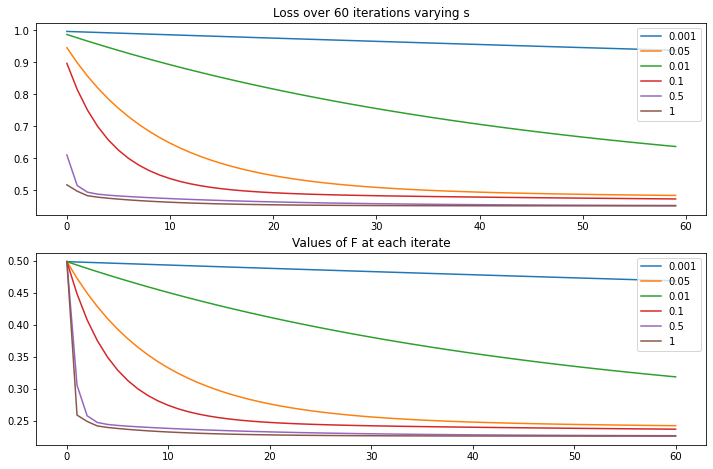

In [44]:
plt.clf
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(3,1,1)
plt.plot(MSEloss.T[1:], label=STEP)
plt.legend()
# plt.ylim(0.4, 2)
plt.title(f'Loss over {max_iter} iterations varying s')

plt.subplot(3,1,2)
plt.plot(vals.T, label=STEP)
plt.legend()
plt.title(f'Values of F at each iterate')

In [45]:
max_iter = 40
theta = np.zeros(X_train.shape[1])
STEP = np.linspace(1, 2, 100)
gamma = (math.sqrt(L)-math.sqrt(mu))**2 / (math.sqrt(L)+math.sqrt(mu))**2 # momentum parameter

iterates = []
vals = []
trainloss = []
for s in STEP:
    i, v, l = heavy_ball(F, gradf, theta, max_iter, mu, L, gamma=gamma, step=s)
    trainloss.append(l[-1])

In [46]:
trainloss = np.array(trainloss)
min_i = trainloss.argmin()

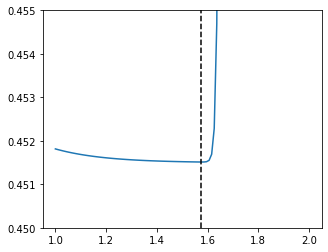

In [47]:
plt.figure(figsize=(5,4))
plt.plot(STEP, trainloss)
plt.ylim(0.45, 0.455)
plt.axvline(x=STEP[min_i], linestyle='dashed', c='k');

In [48]:
beststep = STEP[min_i]
beststep

1.5757575757575757

### Now vary momentum

Fix step size at $\frac{1}{\sqrt{\mu{L}}}$ and for varying values of the momentum parameter $\gamma$:

In [49]:
max_iter = 200
theta = np.zeros(X_train.shape[1])
GAM = [0.0000001, 0.1, 0.0, 1.0, 1.001, 1.1]
s = 1/np.sqrt(mu*L)

iterates = []
vals = []
MSEloss = []
for g in GAM:
    i, v, l = heavy_ball(F, gradf, theta, max_iter, mu, L, gamma=g, step=s)
    iterates.append(i)
    vals.append(v)
    MSEloss.append(l)

iterates = np.array(iterates)
vals = np.array(vals)
MSEloss = np.array(MSEloss)

# print(iterates.shape, vals.shape, MSEloss.shape, len(GAM))

In [50]:
MSEloss.shape

(6, 201)

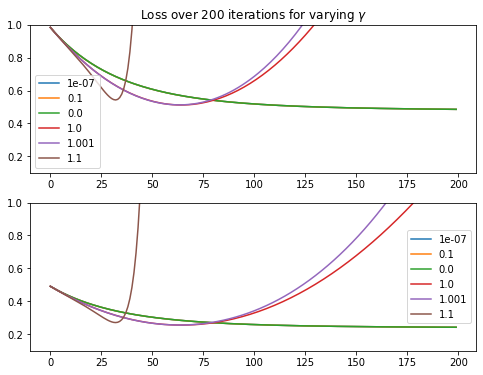

In [51]:
plt.clf
# plt.yscale('log')
plt.rcParams["figure.figsize"] = (8,6)
plt.subplot(2,1,1)
plt.plot(MSEloss.T[1:], label=GAM) #, label=GAM)
plt.legend()
plt.ylim(0.1, 1)
plt.title(f'Loss over {max_iter} iterations for varying $\gamma$')

plt.subplot(2,1,2)
plt.plot(vals.T[1:], label=GAM)
plt.ylim(0.1, 1)
plt.legend()


Finding best $\gamma$

In [52]:
max_iter = 200
theta = np.zeros(X_train.shape[1])
GAM = np.linspace(0.7, 1, 50)
s = 1/np.sqrt(mu*L)

iterates = []
vals = []
trainloss = []
for g in GAM:
    i, v, l = heavy_ball(F, gradf, theta, max_iter, mu, L, gamma=g, step=s)
    trainloss.append(l[-1])

trainloss = np.array(trainloss)
trainloss.shape

(50,)

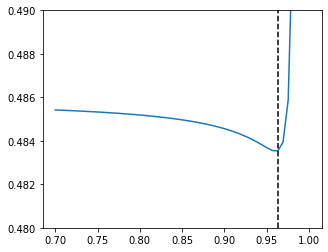

In [53]:
trainloss = np.array(trainloss)
min_i = trainloss.argmin()
np.min(trainloss)
plt.figure(figsize=(5,4))
plt.plot(GAM, trainloss)
plt.ylim(0.48, 0.49)
plt.axvline(x=GAM[min_i], linestyle='dashed', c='k');

In [55]:
bestgamma = GAM[min_i]
bestgamma

0.963265306122449

# Question 2

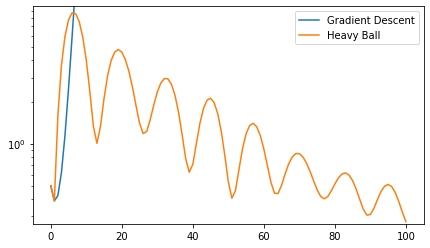

In [81]:
max_iter = 100
theta = np.zeros(X_train.shape[1])

#Gradient Descent
iGD, vGD, lGD = gradient_descent(F, gradf, theta, max_iter, beststep)
#Heavy Ball
gamHB, sHB = [1.0, 0.1]
iHB, vHB, lHB = heavy_ball(F, gradf, theta, max_iter, mu, L, bestgamma, beststep)

plt.figure(figsize=(7,4))
plt.yscale("log")
plt.plot(vGD, label='Gradient Descent')
plt.plot(vHB, label='Heavy Ball')
plt.ylim(np.min(vHB)-1e-2, np.max(vHB)+1)
plt.legend();
 

# **Question 3: Non-convex optimisation**

In [20]:
import numpy as np
import matplotlib.pyplot as plt

Consider now the objective function:
\begin{equation*}
F:\theta \to \frac{1}{2n}||X\theta-y||_2^2 + \lambda||\theta||_{p}, 
\end{equation*}

where $\theta \in \mathbb{R}^{n_0\times n_1}$ and $p \in (0,1)$
which gives the gradient:
\begin{equation*}
\nabla F: \to \frac{1}{n} X^{T} (X\theta-y) + \nabla||\theta||_{p}
\end{equation*}

and 
$$ \nabla{||x||_p} = {||x||_{p}}^{1-p} \cdot [x_1^{p-1}, x_2^{p-1}, \dots, x_n^{p-1}]^T

In [82]:
diff = lambda X, u, y: np.dot(X,u) - y

def F(X, theta, y, p, lmbd):
    return 1/(2*X.shape[0]) * np.linalg.norm(diff(X, theta, y),2)**2 + lmbd*np.linalg.norm(theta, p)

def gradF(X, theta, y, p, lmbd):
    def grad_pnorm(p, x):
        # x = np.abs(x)
        return np.linalg.norm(x,p)**(1-p) * (np.abs(x)**(p-1))

    return (1/X.shape[0]) * (X.T @ diff(X, theta, y)) + grad_pnorm(p, theta)

In [22]:
#Test functions
# p = 1/np.sqrt(2)
# F(X_train, np.zeros(8), y_train, p, 0.1)
# gradF(X_train, np.zeros(8), y_train, p, 0.1)

In [83]:
def gradient_descent(f,grad,x0,T,step):    
    p = np.shape(x0)[0]
    
    # Initialize lists of iterates and objective values
    coefficients = np.zeros((T+1, p))
    function_values = np.zeros(T+1)
    gradnorm = np.zeros(T+1)
    coefficients[0] = x0
    function_values[0] = f(x0)
    gradnorm[0] = np.linalg.norm(grad(x0),2)
    
    x = x0
    for t in range(1,T+1):
        # Descent step
        x = x - step * grad(x)
        # Record
        coefficients[t] = x
        function_values[t] = f(x)
        gradnorm[t] = np.linalg.norm(grad(x), 2)
    
    return (coefficients,function_values, gradnorm)

In [93]:
p = 1/(2)
lmbd = 0.01
F_Q3 = lambda th: F(X_train, th, y_train, p, lmbd)
gradF_Q3 = lambda th: gradF(X_train, th, y_train, p, lmbd)
MSE = lambda X, theta, y: np.mean((np.dot(X,theta)-y)**2)

In [97]:
max_iter = 1200
(theta,vals, grads) = gradient_descent(F_Q3, gradF_Q3, np.ones(X_train.shape[1]), max_iter, step=0.01)
# plot_iterates_2D(iterates)

Final gradient 0.018517187731092823


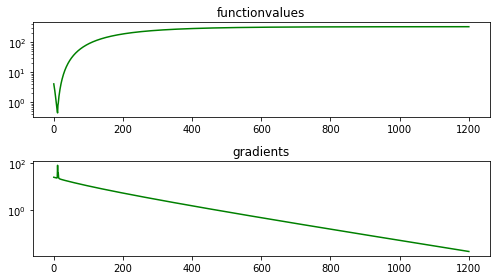

In [106]:
plt.clf
plt.figure(figsize=(7,4), tight_layout=True)
plt.subplot(2,1,1)
plt.plot(vals, c='g', label="gd with non-cvx penalty - cvx")
plt.yscale('log')
plt.title('functionvalues')

plt.subplot(2,1,2)
plt.yscale('log')
plt.plot(grads, c='g', label='gd non-cvx evolution of gradient')
# plt.plot(range(max_iter), np.zeros(max_iter), linewidth=3, c='k')
# plt.ylim(-1, 1e2)
plt.title('gradients');

print('Final gradient', grads[-1])

We have at least an approximate first-order critical point as the gradient at the last iteration has norm ~ 0.019.

Let us now check our ability to predict on the test set

# I'm scaling!

In [135]:
th_star = theta[-1] * 0.01
print(X_train.shape, X_test.shape, th_star.shape)

(16512, 8) (4128, 8) (8,)


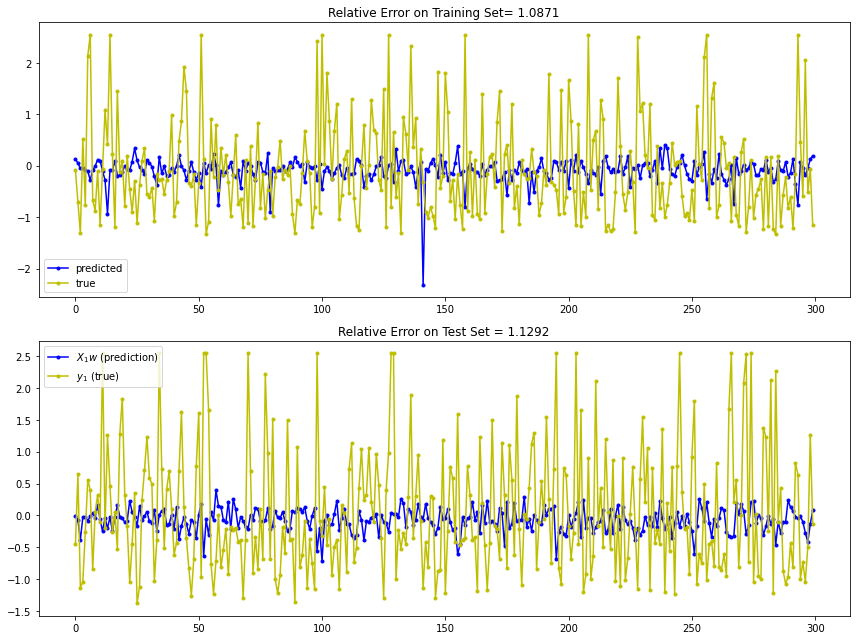

In [136]:
numpredictions=300

plt.clf
plt.figure(figsize= (12,9), tight_layout=True)
plt.subplot(2, 1, 1)
plt.plot( X_train.dot(th_star)[0:numpredictions], 'b.-', label='predicted' )
plt.plot( y_train[0:numpredictions], 'y.-' , label='true')
plt.legend()
rel_err = np.linalg.norm(X_train.dot(th_star) - y_train, 2) / np.linalg.norm(y_train, 2)
plt.title(f'Relative Error on Training Set= {np.round(rel_err, 4)}')

plt.subplot(2, 1, 2)
plt.plot( X_test.dot(th_star)[0:numpredictions], 'b.-', label='$X_1 w$ (prediction)')
plt.plot( y_test[0:numpredictions], 'y.-',label='$y_1$ (true)' )
plt.legend()
rel_err = np.linalg.norm(X_test.dot(th_star) - y_test, 2) / np.linalg.norm(y_test, 2)
plt.title(f'Relative Error on Test Set = {np.round(rel_err, 4)}');

(-2.0, 4.0)

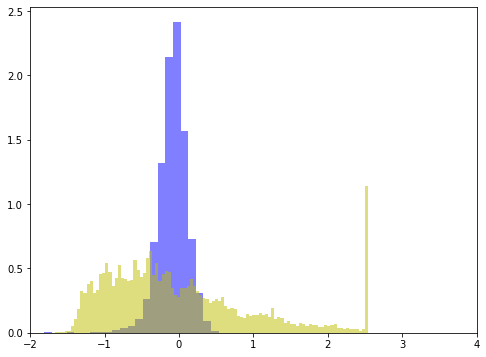

In [137]:
plt.hist(X_train.dot(th_star), bins=100, color='b', alpha=0.5, density=True)
plt.hist(y_train, bins=100, color='y', alpha=0.5, density=True);
plt.xlim(-2, 4)

(-2.0, 4.0)

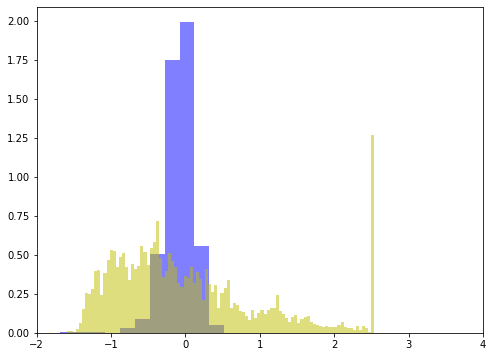

In [138]:
plt.hist(X_test.dot(th_star), bins=100, color='b', alpha=0.5, density=True)
plt.hist(y_test, bins=100, color='y', alpha=0.5, density=True);
plt.xlim(-2, 4)